In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My Drive/FastAI/main

/content/drive/My Drive/FastAI/main


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['uncased-l12-h768-a12', 'jigsaw-toxic-comment-classification-challenge', 'infineon']


In [0]:
from fastai.text import *

In [5]:
train = pd.read_csv("../input/infineon/infineonTrainDataTransformed.csv", encoding="ISO-8859-1")
train.head()

,id,comment_text,Natural Resources,Music and Audio,Platforms,Information Technology,Messaging and Telecommunications,Transportation,Consumer Goods,Real Estate,Video,Navigation and Mapping,Artificial Intelligence,Clothing and Apparel,Administrative Services,Energy,Travel and Tourism,Internet Services,Education,Commerce and Shopping,Sports,Lending and Investments,Sustainability,Biotechnology,Science and Engineering,Data and Analytics,Hardware,Content and Publishing,Gaming,Sales and Marketing,Financial Services,Government and Military,Mobile,Media and Entertainment,Events,Payments,Consumer Electronics,Health Care,Food and Beverage,Software,Professional Services,Design,Agriculture and Farming,Privacy and Security,Advertising,Manufacturing,Community and Lifestyle,Apps
0,35440,enlighted is an iot platform for commercial re...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,13117,darrb is a platform that connects people who w...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,44816,grand perfecta is a leading provider of data a...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,4710,iapp4me offers tools that enable its users to ...,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
4,26697,dealfaint provide top quality products and unp...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


In [0]:
train['comment_text'] = train['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [0]:
train['comment_text'].isna().any()

True

In [0]:
train=train.dropna()

In [0]:
len(train)

40668

In [0]:
test = pd.read_csv("../input/infineon/infineonTestDataTransformed2.csv", encoding="ISO-8859-1")

test_id = test['id']
test['comment_text'] = test['comment_text'].str.replace('([“”¨«»®´·º½¾¿¡§£₤‘’])', '')

In [9]:
test['comment_text'].isna().any()

False

In [0]:
test=test.dropna()

In [10]:
data = (TextList.from_df(train, cols='comment_text')
                .split_by_rand_pct(0.2)
                .label_for_lm()  
                .databunch(bs=48))
data.show_batch()

idx,text
0,"- in - class sensor and analytics platform , we provide smart energy solutions for commercial buildings . our technology reduces costs and improves the comfort of workspaces and the efficiency of the people who work in them . \r\r \n \r\r \n our solutions go beyond theory . customers are saving millions in energy costs - up to 70 % in some instances - while making smarter business"
1,"\r\r\r\r \n \r\r\r\r \n lng production and sales : the company obtains lng from its own liquefaction plants and from third party suppliers . the company owns and operates lng liquefaction plants near houston , texas and boron , california , which it calls the ? pickens plant ? and the ? boron plant ? , respectively . the pickens plant has the capacity to produce 35 million gallons"
2,"and without the need to write computer code . our systems are designed to promote evidence - based and personalised medicine and have been shown to increase compliance with clinical guidelines . access to a deontics xxunk system can be provided to all interested stakeholders including clinicians , providers and patients , allowing for patient participation in decision making , and sophisticated audit capabilities . deontics systems are designed to"
3,"suggest multiple answers for your audience to choose from . \r\r \n 2 . share the interactive poll . ivoted will let people vote via text messages , twitter , emails and the web \r\r \n 3 . votes will come in real time xxbos online marketplace for personal development xxunk is building a platform where people can find and connect with coaches when they want to make"
4,"the world and if students want to continue to grow , being able to understand and speak english is imperative . the jetset esl platform prepares second language english learners better and faster than existing alternatives , which will help them improve their financial growth and provide them better opportunities in the future . \r\r \n \r\r \n the online cultural immersion experience has been heralded by corporations ,"


In [11]:
learn = language_model_learner(data,AWD_LSTM, drop_mult=0.3)

In [12]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


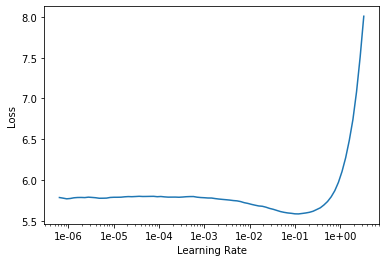

In [13]:
learn.recorder.plot()


In [14]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.593433,4.240865,0.269188,13:18


In [0]:
learn.save_encoder('fine_tuned_enc')

In [0]:
label_cols = ['Natural Resources',
       'Music and Audio', 'Platforms', 'Information Technology',
       'Messaging and Telecommunications', 'Transportation', 'Consumer Goods',
       'Real Estate', 'Video', 'Navigation and Mapping',
       'Artificial Intelligence', 'Clothing and Apparel',
       'Administrative Services', 'Energy', 'Travel and Tourism',
       'Internet Services', 'Education', 'Commerce and Shopping', 'Sports',
       'Lending and Investments', 'Sustainability', 'Biotechnology',
       'Science and Engineering', 'Data and Analytics', 'Hardware',
       'Content and Publishing', 'Gaming', 'Sales and Marketing',
       'Financial Services', 'Government and Military', 'Mobile',
       'Media and Entertainment', 'Events', 'Payments', 'Consumer Electronics',
       'Health Care', 'Food and Beverage', 'Software', 'Professional Services',
       'Design', 'Agriculture and Farming', 'Privacy and Security',
       'Advertising', 'Manufacturing', 'Community and Lifestyle', 'Apps']

In [17]:
test_datalist = TextList.from_df(test, cols='comment_text', vocab=data.vocab)

data_clas = (TextList.from_df(train, cols='comment_text', vocab=data.vocab)
             .split_by_rand_pct(0.2)
             .label_from_df(cols= label_cols , classes=label_cols)
             .add_test(test_datalist)
             .databunch(bs=32))

data_clas.show_batch()

text,target
"xxbos search maximizer offers sem services , including search engine optimization , ppc advertising , and web analytics xxunk maximizer co . ,ltd a a1a,?a a , a?a a , a2a a1a,?a a , a?oa a1a?!a a , a""ca a , a!a a , a?a a , a?a a , aca a , a?a a , a?""a a , a?""a a , a?a a1e?a a , a?a a , a?a",Internet Services;Sales and Marketing;Media and Entertainment;Advertising
"xxbos thai lottery results , real time live stream lottery , update news about thai lotto and a trend xxunk lottery result with a fast update every time , you can check lottery results and read news about lotto on website and mobile . \r\r \n \r\r \n a , sa,?a,?a , ca,?a,- a , aa , ca,2a , ! a , ya,-a,.a1?a,.a,-a,?a,?a1^ a,^a,3a,?a,?a , "" ( siam lottery",Content and Publishing;Gaming;Media and Entertainment;Events;Software;Apps
"xxbos wireco xxunk wire rope , synthetic rope , specialized assemblies , wire products , and electromechanical xxunk worldgroup is the world s leader in manufacturing , engineering , and distributing wire rope , synthetic rope , specialized assemblies , wire products and electromechanical cable . with true global reach , wireco worldgroup can deliver the right products for your equipment and application no matter where your worksite might be",Science and Engineering;Hardware;Mobile;Manufacturing
"xxbos ign entertainment is an online media company that offers services to video game , lifestyle , and entertainment enthusiast markets xxunk entertainment is an online media company that offers services to video game , lifestyle , and entertainment enthusiast markets worldwide . it offers fan - focused information destinations such as ign.com , xxunk , gamespy , and others which are localized into more than 16 languages . it",Internet Services;Gaming;Media and Entertainment;Community and Lifestyle
"xxbos axt , inc . designs , develops , manufactures and distributes high - performance compound semiconductor xxunk , inc . designs , develops , manufactures and distributes high - performance compound semiconductor substrates . our customers use our products to fabricate integrated circuits for electronic systems that operate the latest fiber optic communications , wireless communications and lighting display applications . although our process and products are complex and",Science and Engineering;Hardware;Software;Manufacturing


In [0]:
learn_classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_classifier.load_encoder('fine_tuned_enc')
learn_classifier.freeze() 


In [19]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


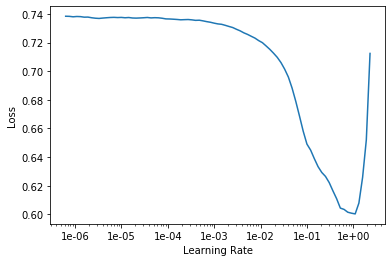

In [20]:
learn_classifier.recorder.plot()


In [21]:
learn_classifier.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,time
0,0.209931,0.194464,03:53


In [22]:
learn_classifier.freeze_to(-2)
learn_classifier.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.199890,0.186283,05:34


In [23]:
learn_classifier.freeze_to(-3)
learn_classifier.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
0,0.188524,0.177290,06:41


In [24]:
learn_classifier.show_results()

text,target,prediction
"xxbos usg is north america s leading producer of gypsum wallboard , joint compound and a vast array of related products for the xxunk corporation is a manufacturer and distributor of innovative , high - performance building systems through its united states gypsum company , usg interiors , llc , and l&w supply corporation subsidiaries and its usg boral building products joint venture . headquartered in chicago , usg worldwide",Real Estate;Science and Engineering;Design;Manufacturing,Hardware;Manufacturing
"xxbos ringcentral , a global distributor of cloud - unified communications and collaboration solutions , offers its users with technology xxunk s cloud - based communication and collaboration platform offers a comprehensive set of capabilities that unify voice , business messaging , team collaboration , video conferencing , and online meetings . \r\r \n \r\r \n ringcentral revolutionizes the power of the cloud to help companies across the globe",Information Technology;Messaging and Telecommunications;Internet Services;Mobile;Software,Information Technology;Messaging and Telecommunications;Internet Services;Hardware;Software
"xxbos xxunk de venezuela s.a . , the state - owned corporation of the bolivarian republic of venezuela , is responsible for the efficient , xxunk de venezuela s.a . , the state - owned corporation of the bolivarian republic of venezuela , is responsible for the efficient , profitable , and dependable exploration , production , refining , transport and commerce of hydrocarbons . this company is deeply committed",Natural Resources;Energy;Sustainability;Government and Military,Natural Resources;Energy;Sustainability;Manufacturing
"xxbos solarwinds develops a technology that manages it xxunk our founding in 1999 , xxunk mission has been to provide purpose - built products that are designed to make jobs easier for it professionals , msps , and devops pros . we offer value - driven products and tools that solve a broad range of it management xxunk those challenges are related to networks , servers , applications , storage",Information Technology;Internet Services;Hardware;Software;Privacy and Security,Information Technology;Internet Services;Hardware;Software;Privacy and Security
xxbos markel ventures makes permanent investments in businesses outside of the specialty insurance xxunk markel ventures they make permanent investments in businesses outside of the specialty insurance marketplace . \r\r \n \r\r \n their focus is long term ... really long term . they do not sell their businesses nor do they use excessive debt . their principal goal is to build profitable enterprises that will endure as part,Commerce and Shopping;Hardware;Financial Services;Health Care;Software;Manufacturing,Lending and Investments;Financial Services


In [25]:
preds, target = learn_classifier.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()

In [0]:
learn_classifier.save('model_attemp1')

In [26]:
labels

array([[3.762281e-05, 1.138984e-02, 1.493446e-01, 8.132238e-02, ..., 9.594854e-01, 2.400047e-04, 7.049996e-03,
        2.587557e-01],
       [5.933628e-04, 3.411468e-02, 7.790807e-01, 8.920287e-02, ..., 4.109214e-02, 1.261337e-03, 3.284514e-02,
        8.200697e-01],
       [2.155264e-02, 2.432932e-04, 5.175462e-02, 5.649921e-01, ..., 2.487882e-02, 8.126442e-03, 1.350580e-02,
        2.441988e-01],
       [9.707876e-02, 2.800819e-03, 1.292989e-03, 1.922395e-01, ..., 1.214025e-03, 9.276448e-01, 5.710210e-03,
        3.423530e-03],
       ...,
       [2.997318e-04, 4.374586e-03, 8.433361e-03, 1.047475e-01, ..., 7.862868e-03, 1.327546e-04, 3.105874e-01,
        6.615304e-02],
       [4.166563e-04, 5.318320e-05, 7.620336e-04, 6.387898e-01, ..., 7.758822e-04, 4.066459e-03, 5.518352e-03,
        1.420527e-02],
       [5.205078e-03, 8.953101e-04, 1.778612e-02, 6.272447e-01, ..., 5.873791e-03, 5.100358e-01, 1.066103e-02,
        3.704220e-02],
       [3.288597e-03, 1.461610e-03, 6.271501e-03, 

In [0]:
target

tensor([0, 0, 0,  ..., 0, 0, 0])

In [27]:
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)

submission.to_csv('submission3.csv', index=False)
submission.head()

,id,Natural Resources,Music and Audio,Platforms,Information Technology,Messaging and Telecommunications,Transportation,Consumer Goods,Real Estate,Video,Navigation and Mapping,Artificial Intelligence,Clothing and Apparel,Administrative Services,Energy,Travel and Tourism,Internet Services,Education,Commerce and Shopping,Sports,Lending and Investments,Sustainability,Biotechnology,Science and Engineering,Data and Analytics,Hardware,Content and Publishing,Gaming,Sales and Marketing,Financial Services,Government and Military,Mobile,Media and Entertainment,Events,Payments,Consumer Electronics,Health Care,Food and Beverage,Software,Professional Services,Design,Agriculture and Farming,Privacy and Security,Advertising,Manufacturing,Community and Lifestyle,Apps
0,53591,0.000038,0.011390,0.149345,0.081322,0.030503,0.002489,0.000759,0.000704,0.017591,0.210259,0.036867,0.001986,0.000270,0.000212,0.007122,0.525570,0.001190,0.083483,0.000769,0.002295,0.000354,0.000072,0.013246,0.435887,0.058174,0.068532,0.007921,0.969859,0.013941,0.000883,0.862991,0.477866,0.005455,0.005543,0.006901,0.001067,0.003228,0.576844,0.002011,0.022361,0.000048,0.005450,0.959485,0.000240,0.007050,0.258756
1,45826,0.000593,0.034115,0.779081,0.089203,0.010033,0.009245,0.003079,0.001587,0.132877,0.061808,0.012410,0.001613,0.000549,0.000529,0.009878,0.235996,0.038362,0.025100,0.006269,0.002163,0.000905,0.001420,0.015396,0.137675,0.058002,0.611286,0.060977,0.046011,0.029110,0.003035,0.947453,0.814063,0.009800,0.011164,0.048057,0.009288,0.002197,0.920413,0.009024,0.019866,0.000055,0.005873,0.041092,0.001261,0.032845,0.820070
2,76744,0.021553,0.000243,0.051755,0.564992,0.005718,0.067057,0.008818,0.077705,0.002454,0.158737,0.275394,0.001788,0.006102,0.052812,0.024181,0.461885,0.003172,0.053945,0.001290,0.005464,0.061057,0.003460,0.177885,0.863550,0.158516,0.039585,0.000885,0.116794,0.037150,0.013212,0.270839,0.060403,0.002798,0.005754,0.069512,0.013836,0.006617,0.946823,0.035483,0.130632,0.007624,0.020813,0.024879,0.008126,0.013506,0.244199
3,51517,0.097079,0.002801,0.001293,0.192239,0.000760,0.122313,0.023734,0.108869,0.001059,0.001064,0.002455,0.000619,0.005646,0.609803,0.000169,0.052762,0.001368,0.026123,0.001723,0.000487,0.287260,0.001108,0.138499,0.008989,0.914117,0.002875,0.000081,0.018785,0.001370,0.006248,0.012665,0.019249,0.000865,0.000173,0.713850,0.002402,0.001396,0.124715,0.006898,0.057554,0.003174,0.007740,0.001214,0.927645,0.005710,0.003424
4,44883,0.034408,0.000068,0.001003,0.258367,0.000815,0.039865,0.001442,0.050831,0.002011,0.001583,0.828063,0.000449,0.003606,0.054240,0.001967,0.100189,0.013285,0.043370,0.000311,0.692762,0.030707,0.027982,0.700732,0.819974,0.110708,0.005027,0.000241,0.031549,0.975167,0.006776,0.053523,0.027915,0.000714,0.220427,0.028350,0.022462,0.000617,0.898794,0.059693,0.019658,0.006166,0.017622,0.007263,0.006587,0.005540,0.021292


In [28]:
copySubmission = submission.copy()
mySubmission = pd.DataFrame()
mySubmission['documentId']= submission['id']
mySubmission['category_groups_list']=''

for index, row in copySubmission.iterrows():
  myStr=''
  myList=list(row[1:])
  myList.sort(reverse=True)
  print(row[0])
  print("-------")
  print(row[1])
  if math.isnan(myList[0])==False:
    myStr=myStr+copySubmission.columns[list(row).index(myList[0])]+","
    myStr=myStr+copySubmission.columns[list(row).index(myList[1])]+","
    myStr=myStr+copySubmission.columns[list(row).index(myList[2])]+","
    myStr=myStr+copySubmission.columns[list(row).index(myList[3])]
    mySubmission.at[index,'category_groups_list']=myStr
    #print(myStr)
  else :
    mySubmission.at[index,'category_groups_list']=' NaN '
  #print(myList)
  

mySubmission.to_csv('mySubmission3.csv', index=False)





53591.0
-------
3.7622812669724226e-05
45826.0
-------
0.0005933627835474908
76744.0
-------
0.021552637219429016
51517.0
-------
0.09707875549793243
44883.0
-------
0.03440754488110542
60983.0
-------
0.00012022781447740272
71046.0
-------
0.0012712549651041627
3780.0
-------
0.004428878426551819
2782.0
-------
8.119425910990685e-05
7105.0
-------
0.0005999357090331614
49132.0
-------
0.0005942717543803155
2651.0
-------
0.012018777430057526
7515.0
-------
0.12400784343481064
42233.0
-------
0.00017629859212320298
71054.0
-------
0.0005939736147411168
52288.0
-------
0.001940765418112278
30643.0
-------
0.00100803526584059
50589.0
-------
0.0010206723818555474
26194.0
-------
0.0005797448684461415
4500.0
-------
0.6148005723953247
63904.0
-------
0.002661588368937373
16473.0
-------
0.000771234801504761
53851.0
-------
0.004049800336360931
66878.0
-------
9.464222239330411e-05
75731.0
-------
0.04370653256773949
16590.0
-------
0.00023163938021752983
77107.0
-------
0.0124603742733597

In [29]:
len(mySubmission)

4999